# ML-Lecture5.2

In [1]:
import sys
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import sys

# or wherever you have saved the repo
sys.path.append('/Users/tlee010/Desktop/github_repos/fastai/')

from fastai.imports import *
from fastai.structured import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

### Previously: Random Forests in General

Downside - can't extrapolate very well. 

They are a great starting point. There's a huge catalog of machine learning tools out there. Books don't curate it down. Why would you use a Support Vector Machine today? Theoretically elegant, and exciting previously, but practically dont see them having any place today.

Hard to write about Random Forests, since its hard to look at it theoretically. GBM / XGBOOST etc. Now industry is more invested in the algorithms and are doing more work.

Packages being used today , top 5 or 6 did not exist more than 3 years ago.

**Examples**:
- Feature interactions for RF?

##### How big should your validation set be? 

First need to answer the question, how accurate does this algorithm need to be? 

|parameter | model 1| model 2|
|-----------|--------|-------|
|n|2000|2000|
|acc|99.4%|99.2%|
|wrong|12|16|
|cats|50%|50%|
|wrong cats|6|8|

There's a practical consideration here. 0.2% could be a big deal depending on what the application. 22 is where the t distribution turns into a normal distribution.

**Rule of Thumb 1** - Once we have a n > 22, it behaves more normally. So 22 out of 1000 etc. 

**Rule of Thumb 2** - If you have binomial data

|Metric |Binomial |
|----|----|
|np | mean|
|np(1-p)|std|
|std/sqrt(n)|SE|

**Rule of Thumb 3** - training set should have an equal number of the rare object, you should over sample until its the same size as the common class. There's also a way to weight the uncommon class, so its picked more often

** one shot learning ** - recognize somethign that you have only seen once
** zero shot learning ** - not covered in this class, but recognize something you never seen before

## 1. Returning to our Random Forest Class

HW - add all the other RF interpretations that we have already covered

In [5]:
import feather
df_raw = feather.read_dataframe('/Users/tlee010/kaggle/bulldozers/bulldozers-raw')
print('import complete')

import complete


In [7]:
df_trn, y_trn, nas = proc_df(df_raw, 'SalePrice')

In [8]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [9]:
x_sub = X_train[['YearMade', 'MachineHoursCurrentMeter']]

### 1.1 Basic Data Structure

In [15]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]
    
    def create_tree(self):
        # get random indexes
        rnd_idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        
        # then return a decision tree based on a random dataset
        return DecisionTree(self.x.iloc[rnd_idxs], self.y[rnd_idxs], min_leaf=self.min_leaf)
        
    def predict(self, x):
        
        # currently returning the mean of the prediction of all the 
        # trees
        return np.mean([t.predict(x) for t in self.trees], axis=0)

### 1.2 Decision Tree Version 1

In [16]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf

## 2. Now we need to flesh out the decision Tree.

We are going to write it as if everything exists

### 2.1 Decision Tree Version 2

In [17]:
class DecisionTree():
    def __init__(self, x, y, idxs=None, min_leaf=5):
        """
        x : input features
        y : target variable
        idxs: keep track of what rows went where
        """
        
        # if its the first run, set to all
        if idxs is None: idxs=np.arange(len(y))
            
        # store the data, and count rows and cols
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        
        # every node in the tree will have the mean
        # target variable
        self.val = np.mean(y[idxs])
        
        # how effective was the split at this tree
        # only if not a leaf node
        self.score = float('inf')
        
        # having building root, which vari
        # should we split and how much should we split on?
        self.find_varsplit()
        
        
    # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        
        # go through each variable, and find a better split
        # assuming all features are sent
        for i in range(self.c): self.find_better_split(i)
            
    # We'll write this later!
    def find_better_split(self, var_idx): pass
    
    
    """
    Property means, dont need to call ()
    will be calculated on the fly
    """
    
    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]
        
    @property
    def is_leaf(self): return self.score == float('inf')

        
    def __repr__(self):
        """
        This is overloading the print function
        so that everytime we print the decision tree
        it will print some sort of data
        """
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

In [18]:
m = TreeEnsemble(X_train, y_train, n_trees=10, sample_sz=1000, min_leaf=3)

#### Test our __repr___ implementation

In [ ]:
m.trees[0]

#### Look at all the indexes in the tree (hint: all)

In [21]:
m.trees[0].idxs[:10]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

###  2.2 Comparison to Sklearn

In [22]:
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
x_samp,y_samp = tree.x, tree.y
x_samp.columns

Index(['YearMade', 'MachineHoursCurrentMeter'], dtype='object')

#### Scikit Learn - 1 Tree, 1 Decision, No bootstrapping

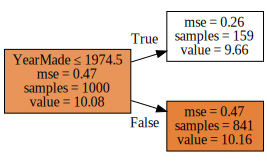

In [23]:
m = RandomForestRegressor(n_estimators=1, max_depth=1, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

#### For our function - `find a better split`

Given this subset of a data we are going to try to find a value to split on. We will find the split that minimizes the stddev of each group. Its the same as minimizing RMSE

|YM|Price | group 1 | group 2|
|--|--|------| -----|
|3|1||
|4|1||
|1|0||
|6|1||
|4|0||
|1|0||

### Find Better Split v1

Let's implement. Remember previously:
```python
 # We'll write this later!
    def find_better_split(self, var_idx): pass
```

In [25]:
def find_better_split(self, var_idx):
    """
    will get the indexes 
    """
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    # go through every single value
    for i in range(1,self.n-1):
        
        # separate out the data, arrays of booleans
        # since doing a comparative
        lhs = x<=x[i]
        rhs = x>x[i]
        
        # if there's no real split, then stop
        if rhs.sum()==0: continue
            
        # otherwise calculate the two STDs
        lhs_std = y[lhs].std()
        rhs_std = y[rhs].std()
        
        #then average the score
        curr_score = lhs_std*lhs.sum() + rhs_std*rhs.sum()
        
        # is this better than our score so far
        # its intialized as inf.
        # if its better, then we store
        # variable, ID, SCORE, and what it is
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,x[i]

#### From Above

```python
ens = TreeEnsemble(x_sub, y_train, 1, 1000)
tree = ens.trees[0]
```

In [26]:
%timeit find_better_split(tree,1)
tree

75.7 ms ± 1.01 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


n: 1000; val:10.079014121552744; score:681.0184057251435; split:3744.0; var:MachineHoursCurrentMeter

### Test it out on a tree

In [27]:
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade

### Baseline Computational Complexity? n^2

- Consider loops
- Sorts
- comparisons

```python
    # will do n times
    for i in range(1,self.n-1):
        
        # will also compare against all values so N again
        lhs = x<=x[i]
        rhs = x>x[i]
```

## 3. Find Better Split : Speeding Things up

In [30]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]

#### Variance

$$ mean(xy) - mean(x)mean(y) $$

Common language: sort the data, keep track of sum + count of the dataset and go through the dataset once. And if we have  sum + count, we can keep calculating the mean. 

|YM|Price |
|--|--|
|1|0|
|1|0|
|3|1|
|4|1|
|4|0|
|6|1|

In [31]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

### 3.1 Find Better Split v2

In [32]:
def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

def find_better_split(self, var_idx):
    x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
    
    sort_idx = np.argsort(x)
    sort_y,sort_x = y[sort_idx], x[sort_idx]
    rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
    lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

    for i in range(0,self.n-self.min_leaf-1):
        xi,yi = sort_x[i],sort_y[i]
        lhs_cnt += 1; rhs_cnt -= 1
        lhs_sum += yi; rhs_sum -= yi
        lhs_sum2 += yi**2; rhs_sum2 -= yi**2
        if i<self.min_leaf or xi==sort_x[i+1]:
            continue
            
        lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
        rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
        curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
        if curr_score<self.score: 
            self.var_idx,self.score,self.split = var_idx,curr_score,xi

In [33]:
%prun find_better_split(tree,1)

#### Example Output

```bash
         797 function calls (793 primitive calls) in 0.002 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.001    0.001    0.002    0.002 <ipython-input-32-89db6b5dcd57>:3(find_better_split)
      318    0.000    0.000    0.000    0.000 <ipython-input-32-89db6b5dcd57>:1(std_agg)
        1    0.000    0.000    0.000    0.000 internals.py:3675(_interleave)
        3    0.000    0.000    0.000    0.000 {method 'reduce' of 'numpy.ufunc' objects}
        1    0.000    0.000    0.000    0.000 {method 'argsort' of 'numpy.ndarray' objects}
      318    0.000    0.000    0.000    0.000 {built-in method math.sqrt}
        1    0.000    0.000    0.002    0.002 {built-in method builtins.exec}
        2    0.000    0.000    0.000    0.000 numerictypes.py:942(_can_coerce_all)
        1    0.000    0.000    0.000    0.000 cast.py:1049(find_common_type)
        1    0.000    0.000    0.000    0.000 generic.py:3661(_protect_consolidate)
    32/28    0.000    0.000    0.000    0.000 {built-in method builtins.len}
 ...
 ```

### 3.2 Python Method for assigning functions, (assigning Find Better Split) 

```
DecisionTree.find_better_split = find_better_split
```

**`DecisionTree.find_better_split`** - our method in our custom class

**`find_better_split`** <- the v2 of the find_better_split

In [35]:
DecisionTree.find_better_split = find_better_split

In [36]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

#### Note this is the same as what we ran separately before (see a few blocks up)

```python
find_better_split(tree,0); tree

n: 1000; val:10.079014121552744; score:658.5510186055949; split:1974.0; var:YearMade
```

## 4. How to do more than 1 level?

### Back to Scikit Learn Comparison with 2 levels

Now we will have to find a decision split in both child nodes to make the next level down.

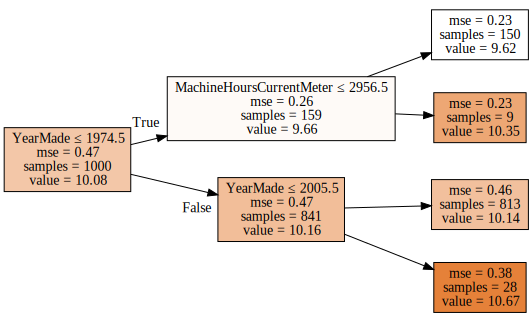

In [37]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2)

### 4.1 Find_varsplit version 2 (improvements)
 
Old version:

```python
  # This just does one decision; we'll make it recursive later
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
```

In [38]:
def find_varsplit(self):
    
    # is there something better
    for i in range(self.c): self.find_better_split(i)
    if self.is_leaf: return
    x = self.split_col
    
    # gets the boolean array, but gets the indexes
    lhs = np.nonzero(x<=self.split)[0]
    rhs = np.nonzero(x>self.split)[0]
    
    # now that we have the indexes we can create a decision tree
    self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
    self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

#### Assign it to our class

In [39]:
DecisionTree.find_varsplit = find_varsplit

In [40]:
tree = TreeEnsemble(x_sub, y_train, 1, 1000).trees[0]; tree

n: 1000; val:10.079014121552744; score:658.5510186055565; split:1974.0; var:YearMade

### 4.2 Checking Answers

#### Lets look at the left hand and right hand side

In [41]:
tree.lhs

n: 159; val:9.660892662981706; score:76.82696888346362; split:2800.0; var:MachineHoursCurrentMeter

In [42]:
tree.rhs

n: 841; val:10.158064432982941; score:571.4803525045031; split:2005.0; var:YearMade

#### What about level2

In [43]:
tree.lhs.lhs

n: 150; val:9.619280538108496; score:71.15906938383463; split:1000.0; var:YearMade

In [44]:
tree.lhs.rhs

n: 9; val:10.354428077535193

In [46]:
tree.rhs.lhs

n: 813; val:10.140438373816052; score:550.1806493212129; split:1994.0; var:YearMade

In [47]:
tree.rhs.rhs

n: 28; val:10.669849650935848; score:16.460871194578985; split:895.0; var:MachineHoursCurrentMeter

#### Again compare to Sklearn (look at samples)

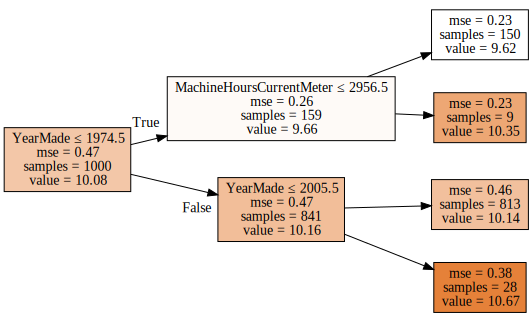

In [45]:
draw_tree(m.estimators_[0], x_samp, precision=2)

## 5. Writing our RF Predictor

Lets look through a basic prototype of the prediction function

In [53]:
cols = ['MachineID', 'YearMade', 'MachineHoursCurrentMeter', 'ProductSize', 'Enclosure',
        'Coupler_System', 'saleYear']

In [54]:
%time tree = TreeEnsemble(X_train[cols], y_train, 1, 1000).trees[0]
x_samp,y_samp = tree.x, tree.y

CPU times: user 287 ms, sys: 6.72 ms, total: 294 ms
Wall time: 293 ms


#### The Sk learn version

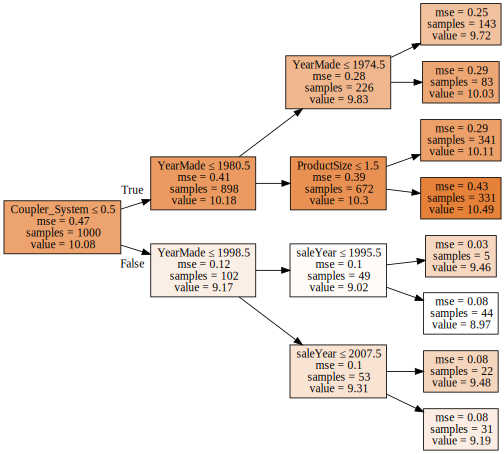

In [56]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False)
m.fit(x_samp, y_samp)
draw_tree(m.estimators_[0], x_samp, precision=2, ratio=0.9, size=7)

In [57]:
def predict(self, x): return np.array([self.predict_row(xi) for xi in x])
    
DecisionTree.predict = predict

#### Inline If functions

```python
if x > 1:
    x = "greater"
else:
    x ="lesser"
```

Can be written as the following:

```python
x = "greater" if x > 1 else "lesser"
```

In [58]:
def predict_row(self, xi):
    
    #if leaf return
    if self.is_leaf: return self.val
    
    # otherwise return lhs or right hand side
    # this is an exampel of inline if value
    t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
    return t.predict_row(xi)

DecisionTree.predict_row = predict_row

In [59]:
%time preds = tree.predict(X_valid[cols].values)

CPU times: user 89 ms, sys: 2.18 ms, total: 91.2 ms
Wall time: 90.6 ms


## 6. Looking at scores

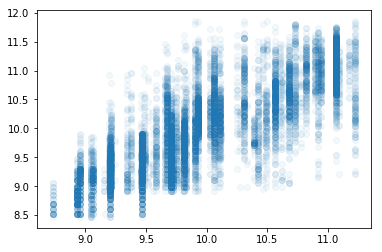

In [60]:
plt.scatter(preds, y_valid, alpha=0.05)

In [61]:
metrics.r2_score(preds, y_valid)

0.50371522136882341

### Compare to the Sklearn Plot

CPU times: user 3.38 ms, sys: 632 µs, total: 4.02 ms
Wall time: 3.44 ms


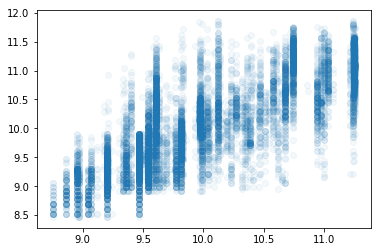

In [62]:
m = RandomForestRegressor(n_estimators=1, min_samples_leaf=5, bootstrap=False)
%time m.fit(x_samp, y_samp)
preds = m.predict(X_valid[cols].values)
plt.scatter(preds, y_valid, alpha=0.05)

In [63]:
metrics.r2_score(preds, y_valid)

0.47541053100694763

## 6. Assembling the Final Version

And below we cut and paste all the necessary functions and collect it in two neat classes as listed down below

In [64]:
class TreeEnsemble():
    def __init__(self, x, y, n_trees, sample_sz, min_leaf=5):
        np.random.seed(42)
        self.x,self.y,self.sample_sz,self.min_leaf = x,y,sample_sz,min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], 
                    idxs=np.array(range(self.sample_sz)), min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

In [ ]:
class DecisionTree():
    def __init__(self, x, y, idxs, min_leaf=5):
        self.x,self.y,self.idxs,self.min_leaf = x,y,idxs,min_leaf
        self.n,self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in range(self.c): self.find_better_split(i)
        if self.score == float('inf'): return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        self.lhs = DecisionTree(self.x, self.y, self.idxs[lhs])
        self.rhs = DecisionTree(self.x, self.y, self.idxs[rhs])

    def find_better_split(self, var_idx):
        x,y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf')
    
    def __repr__(self):
        s = f'n: {self.n}; val:{self.val}'
        if not self.is_leaf:
            s += f'; score:{self.score}; split:{self.split}; var:{self.split_name}'
        return s

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [66]:
!pip install Cython

In [71]:
!conda install Cython

Fetching package metadata ...........
Solving package specifications: .

Package plan for installation in environment /Users/tlee010/anaconda/envs/dsi:

The following packages will be UPDATED:

    cython: 0.24-py27_0 --> 0.26.1-py27h6a053f9_0

Proceed ([y]/n)? ^C


## 7. Cython - more speed improvements

A super set of python

In [1]:
%load_ext Cython

#### Pure Python

In [2]:
def fib1(n):
    a, b = 0,1
    while b < n:
        a,b = b, a +b

In [5]:
%timeit fib1(50)

308 ns ± 8.24 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


#### Cython Wrapper

In [6]:
%%cython
def fib2(n):
    a, b = 0,1
    while b < n:
        a,b = b, a +b

In [7]:
%timeit fib2(50)

306 ns ± 6.26 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


#### Cython version with Typing Specified

In [16]:
%%cython
def fib3(int n):
    cdef int b = 1
    cdef int a = 0
    cdef int t = 0
    while b < n:
        t = a
        a = b
        b = t + b

In [17]:
%timeit fib3(50)

51.4 ns ± 0.903 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


### Homework

#### Confidence Based Tree Variance
#### Feature Importance
#### Partial Dependence
#### Tree Interpreter
#### Bonus : Interaction Importance